In [1]:
import datetime as dt
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)
from sklearn.gaussian_process import kernels
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler
from src.step3_modeling.ensemble import DefaultEnsemble
from src.step3_modeling.gaussian_process import SklearnGPModel, LaggedGPModel
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase, SklearnRegressorModel
from src.step3_modeling.var_models import VAR
from src.step3_modeling.nn import BayesNN
from src.utils import create_rnbs_snapshot, flatten_array

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
def split_data(split_date, lake_data, validation_steps=12, num_years_ahead=1):
    covars = lake_data.sel(type="Basin")[["precip", "evap", "temp"]].to_array().transpose("Date", "lake", ...)
    y_scaler = XArrayScaler()
    y_vals = y_scaler.fit_transform(lake_data["rnbs"])
    lake_snapshot = create_rnbs_snapshot(rnbs_data=y_vals,
                                         covariates=covars,
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    return lake_snapshot, y_scaler


lake_data = load_data(["rnbs", "precip", "evap", "temp"]).dropna("Date").transpose("Date", "lake", ...)

train_split = dt.datetime(1999, 12, 1)
snapshot, y_scaler = split_data(train_split, lake_data)

scaled_rnbs = XArrayScaler().fit_transform(lake_data["rnbs"])

snapshot.train_y

<xarray.DataArray 'rnbs' (Date: 240, lake: 4)>
array([[-1.18710356e+00, -4.79767891e-01,  1.18010055e-01,
         7.31526068e-01],
       [-3.96996869e-01, -4.91255064e-01,  5.88664558e-01,
        -4.76262581e-01],
       [ 1.14108578e+00,  2.22787517e+00,  1.79230574e+00,
         2.43288709e+00],
       [ 1.68939841e+00,  2.64999989e+00,  2.12747371e+00,
         2.32571709e+00],
       [ 2.74053276e+00,  1.54775618e+00,  6.15514984e-01,
         4.55629065e-01],
       [ 2.00538007e+00,  9.76609632e-01,  1.18318677e-01,
        -4.22121578e-01],
       [ 6.82073093e-01, -2.10286873e-01, -3.79495056e-01,
        -8.89365459e-01],
       [-1.35448004e-02,  5.11536952e-01, -4.27332080e-01,
        -8.89365459e-01],
       [-7.36880909e-02, -1.65610865e+00, -4.83502002e-01,
        -7.11367806e-01],
       [ 1.99399453e-01, -8.32659707e-01, -1.03007872e+00,
        -4.98512247e-01],
...
       [ 1.75738932e-01,  1.84611056e+00,  1.39047495e+00,
         2.30643457e+00],
       [ 1.36966346e-01,  1.30569910e+00,  1.48861797e+00,
         9.12861068e-01],
       [ 3.36630097e-01,  4.95497598e-01, -6.36624541e-03,
         1.87932380e-02],
       [ 9.42948620e-01,  2.56337677e-01, -1.96479854e-01,
        -1.05023124e-02],
       [-4.86753914e-01, -1.10534895e+00, -5.23006129e-01,
        -6.59451810e-01],
       [-7.32822781e-01, -6.49797638e-01, -6.47382439e-01,
        -9.46843892e-01],
       [-1.06284802e+00, -1.53813305e+00, -1.75195498e+00,
        -1.60135615e+00],
       [-1.05460497e+00, -1.67318399e+00, -1.69979679e+00,
        -1.72855032e+00],
       [-5.31632581e-01, -9.14104313e-01, -1.78898968e+00,
        -1.27873540e+00],
       [-1.08772972e+00, -1.44861652e+00, -1.03007872e+00,
        -1.18825324e+00]])
Coordinates:
  * Date     (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 1998-12-01
  * lake     (lake) object 'sup' 'mic_hur' 'eri' 'ont'

In [3]:
preprocessor = Pipeline(steps=[
    ("scale", XArrayScaler()),
    ("flatten", FunctionTransformer(flatten_array))
])

all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    "GP_RQMatern": Pipeline(steps=[("preprocessor", preprocessor),
                                   ("model", SklearnGPModel(1.0 * kernels.Matern() * kernels.RationalQuadratic()))]),
    "EnsembleNN": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model",
         SklearnRegressorModel(
             sklearn_regressor=MLPRegressor(solver="lbfgs", hidden_layer_sizes=(100,), max_iter=1000,
                                            activation="relu"),
             n_estimators=250, n_jobs=-1)),
    ]),
    "LM": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", SklearnRegressorModel(sklearn_regressor=LinearRegression())),
    ]),
    "VAR": Pipeline(steps=[
        ("preprocess", XArrayScaler()),
        (
            "model",
            VAR(lags={"y": 3, "temp": 6, "evap": 3, "precip": 1}, num_warmup=1500, num_chains=4, num_samples=1000)
        )
    ]),
}



In [4]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_rnbs.rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot, _ = split_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=12)

        months_ahead = xr.DataArray(np.arange(1, 13), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot, y_scaler = split_data(train_split, lake_data, num_years_ahead=10, validation_steps=0)
all_model_results = []
fitted_models = {}
for name, model in all_models.items():
    fitted_model = fit_model(snapshot, model)
    fitted_models.update({name: fitted_model})
    predictions = run_forecasts(train_split, model).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

value,Date,lake,months_ahead,true,lower,mean,std,upper,model
0,2000-01-01,eri,1.0,-0.723922,-0.834904,0.250040,0.738549,1.620572,Default
1,2000-01-01,mic_hur,1.0,-1.021938,-0.925053,-0.341498,0.432974,0.273175,Default
2,2000-01-01,ont,1.0,-0.601973,-1.050880,0.096964,0.844409,1.682219,Default
3,2000-01-01,sup,1.0,-1.078265,-1.381474,-1.077792,0.298238,-0.461082,Default
4,2000-02-01,eri,2.0,0.143626,-0.436220,0.419205,0.695108,1.604662,Default


In [5]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  \
months_ahead model                                                 
1.0          Default      0.657192  0.428308  0.059941  0.824380   
             EnsembleNN   0.482822  0.232587 -0.023028  0.884298   
             GP_RQMatern  0.404606  0.162323 -0.037193  0.940083   
             LM           0.471059  0.221840 -0.007511  0.419421   
             VAR          0.381228  0.140296 -0.070982  0.900826   
2.0          Default      0.656565  0.427585  0.059102  0.822314   
             EnsembleNN   0.486809  0.236512 -0.021721  0.880165   
             GP_RQMatern  0.407604  0.164914 -0.035029  0.938017   
             LM           0.478340  0.228808 -0.000710  0.415289   
             VAR          0.387545  0.144114 -0.077954  0.902893   
3.0          Default      0.657148  0.428409  0.058607  0.824380   
             EnsembleNN   0.487103  0.236743 -0.022936  0.882231   
             GP_RQMatern  0.408259  0.165160 -0.038929  0.938017   
             LM           0.478083  0.228534 -0.005375  0.417355   
             VAR          0.387217  0.143042 -0.083035  0.900826   
4.0          Default      0.664661  0.437316  0.066766  0.822314   
             EnsembleNN   0.491493  0.241218 -0.018626  0.880165   
             GP_RQMatern  0.412226  0.168709 -0.034949  0.935950   
             LM           0.477733  0.228225 -0.002057  0.417355   
             VAR          0.390462  0.146871 -0.074763  0.909091   
5.0          Default      0.664953  0.437694  0.066841  0.820248   
             EnsembleNN   0.491578  0.241184 -0.021564  0.882231   
             GP_RQMatern  0.412335  0.168641 -0.037136  0.935950   
             LM           0.477851  0.228335 -0.002531  0.419421   
             VAR          0.389718  0.146103 -0.076005  0.909091   
6.0          Default      0.664214  0.436759  0.066491  0.822314   
             EnsembleNN   0.490864  0.240524 -0.020583  0.882231   
             GP_RQMatern  0.412151  0.168414 -0.038138  0.935950   
             LM           0.477456  0.227955 -0.002987  0.421488   
             VAR          0.389564  0.146077 -0.075392  0.907025   
7.0          Default      0.660370  0.430418  0.075303  0.824380   
             EnsembleNN   0.491466  0.241097 -0.021031  0.878099   
             GP_RQMatern  0.412113  0.168458 -0.037135  0.935950   
             LM           0.477271  0.227786 -0.000981  0.419421   
             VAR          0.389477  0.146273 -0.073617  0.915289   
8.0          Default      0.659342  0.428995  0.075747  0.824380   
             EnsembleNN   0.498780  0.248046 -0.027126  0.871901   
             GP_RQMatern  0.415648  0.171048 -0.041407  0.931818   
             LM           0.478379  0.228821 -0.005067  0.421488   
             VAR          0.391435  0.147150 -0.077919  0.911157   
9.0          Default      0.659211  0.428511  0.077772  0.824380   
             EnsembleNN   0.501457  0.250919 -0.023253  0.871901   
             GP_RQMatern  0.416100  0.171537 -0.040021  0.931818   
             LM           0.478849  0.229276 -0.004455  0.423554   
             VAR          0.391607  0.147051 -0.079407  0.913223   
10.0         Default      0.659454  0.429106  0.075988  0.824380   
             EnsembleNN   0.503085  0.252499 -0.024386  0.871901   
             GP_RQMatern  0.417927  0.172887 -0.042142  0.929752   
             LM           0.480049  0.230393 -0.007308  0.423554   
             VAR          0.394394  0.148780 -0.082258  0.907025   
11.0         Default      0.659037  0.428485  0.076447  0.824380   
             EnsembleNN   0.504180  0.253694 -0.022417  0.869835   
             GP_RQMatern  0.418379  0.173315 -0.041543  0.929752   
             LM           0.481326  0.231652 -0.004729  0.425620   
             VAR          0.395010  0.149304 -0.082029  0.911157   
12.0         Default      0.659417  0.429046  0.076058  0.822314   
             EnsembleNN   0.504270  0.253785 -0.022440  0.871901   
             GP_RQ

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanea

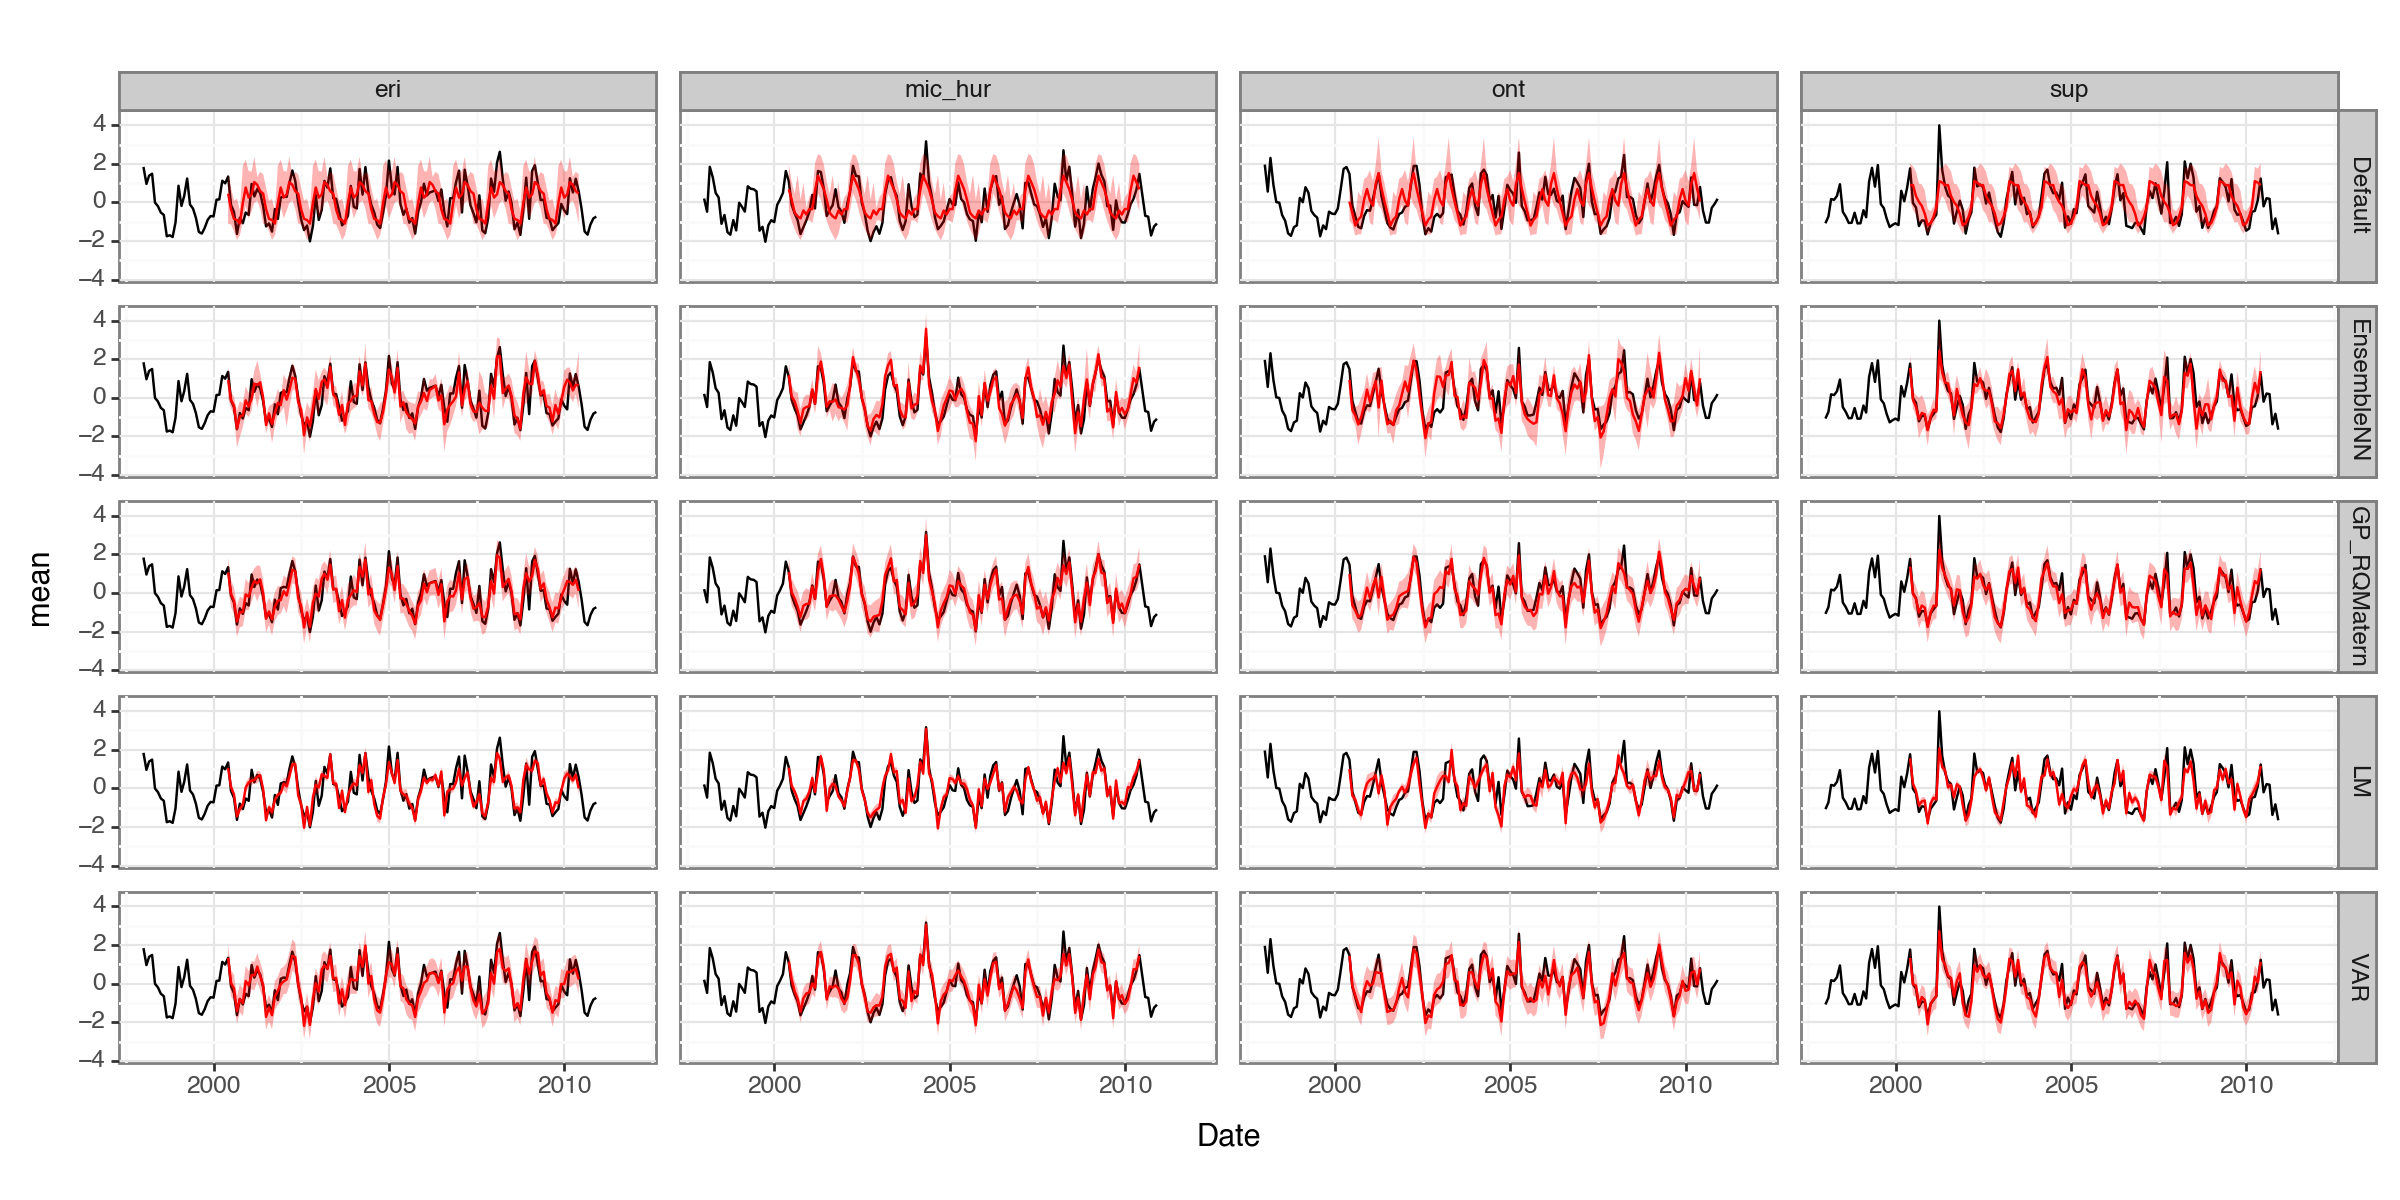

<Figure Size: (1200 x 600)>

In [6]:
og = scaled_rnbs.to_dataframe(name="rnbs").reset_index()
result_subset = results_df[results_df["months_ahead"].isin([6])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean"), color="red")
        + facet_grid("model~lake")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)


In [7]:
model = fitted_models["VAR"].steps[-1][1]

In [8]:
az.plot_trace(model.trace)

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values


array([[<Axes: title={'center': 'corr'}>,
        <Axes: title={'center': 'corr'}>],
       [<Axes: title={'center': 'evap_alpha'}>,
        <Axes: title={'center': 'evap_alpha'}>],
       [<Axes: title={'center': 'global_mu'}>,
        <Axes: title={'center': 'global_mu'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'intercept_decentered'}>,
        <Axes: title={'center': 'intercept_decentered'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'precip_alpha'}>,
        <Axes: title={'center': 'precip_alpha'}>],
       [<Axes: title={'center': 'temp_alpha'}>,
        <Axes: title={'center': 'temp_alpha'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'y_alpha'}>,
        <Axes: title={'center': 'y_alpha'}>]], dtype=object)

In [ ]:
from matplotlib import pyplot as plt

plt.show()